In [1]:
# Grant Waldow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/CS760/HW2

/content/drive/MyDrive/CS760/HW2


In [111]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [112]:
def entropy(s):
    if len(s) == 0: return 0
    p = sum(1 for _, _, y in s if y == 1) / len(s) # % of + cases in the set
    if p == 0 or p == 1: return 0 # 0 entropy if homogeneous
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p) # return the entropy

def calculate_split_info(s1, s2):
    total = len(s1) + len(s2)
    if len(s1) == 0 or len(s2) == 0: return 0
    return - (len(s1)/total) * math.log2(len(s1)/total) - (len(s2)/total) * math.log2(len(s2)/total)

def calculate_split_gain_ratio(s, f, threshold):
    s1 = [(x1, x2, y) for x1, x2, y in s if f(x1, x2) >= threshold] # split data on threshold
    s2 = [(x1, x2, y) for x1, x2, y in s if f(x1, x2) < threshold]
    gain = entropy(s) - len(s1) / len(s) * entropy(s1) - len(s2) / len(s) * entropy(s2)
    s_info = calculate_split_info(s1, s2)

    return 0 if s_info == 0 else gain / s_info

def decision_tree_func(s):
    # Stopping criterion: empty set or entropy of set is 0.
    if len(s) == 0 or entropy(s) == 0:
        return lambda _: 1 if sum(1 for _, _, y in s if y == 1) >= len(s) / 2 else 0

    gain_ratios = []
    for i in range(2):
        for x1, x2, y in s:
            threshold = x1 if i == 0 else x2
            g_ratio = calculate_split_gain_ratio(s, (lambda a, b: a if i == 0 else b), threshold) # info gain ratio
            if g_ratio > 0: gain_ratios.append((g_ratio, i, threshold))

    # stopping criteria: gain ratio <= 0
    if not gain_ratios:
        return lambda _: 1 if sum(1 for _, _, y in s if y == 1) >= len(s) / 2 else 0

    _, i, threshold = max(gain_ratios)
    s1 = [(x1, x2, y) for x1, x2, y in s if (x1 if i == 0 else x2) >= threshold]
    s2 = [(x1, x2, y) for x1, x2, y in s if (x1 if i == 0 else x2) < threshold]
    tree1 = decision_tree_func(s1)
    tree2 = decision_tree_func(s2)

    def tree(x):
        if (x[0] if i == 0 else x[1]) >= threshold:
            return tree1(x)
        else:
            return tree2(x)

    return tree

# Test
with open('D1.txt') as f:
    data = [tuple(map(float, line.split())) for line in f]

tree = decision_tree_func(data)

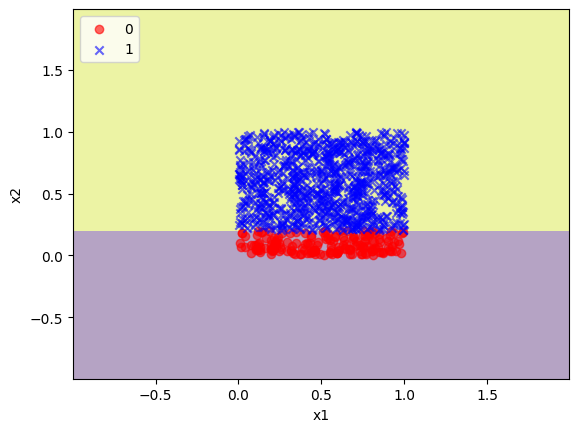

In [113]:
def plot_decision_boundary(tree, data, resolution=0.01):
    # Find min and max of the data
    x1_values, x2_values, labels = zip(*data)
    x1_min, x1_max = min(x1_values)-1, max(x1_values)+1
    x2_min, x2_max = min(x2_values)-1, max(x2_values)+1
    # using a grid
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    # Use the decision tree to predict class
    Z = np.array([tree((x1, x2)) for x1, x2 in zip(np.ravel(xx1), np.ravel(xx2))])
    Z = Z.reshape(xx1.shape)
    # Plot the decision boundaries
    plt.contourf(xx1, xx2, Z, alpha=0.4)

    plt.scatter(x=[x1 for x1, x2, y in data if y == 0],y=[x2 for x1, x2, y in data if y == 0],alpha=0.6, c='r', marker='o', label='0')
    plt.scatter(x=[x1 for x1, x2, y in data if y == 1],y=[x2 for x1, x2, y in data if y == 1],alpha=0.6, c='b', marker='x', label='1')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='upper left')
    plt.show()


# Plot the decision boundaries
plot_decision_boundary(tree, data)


In [114]:
# simple accuracy (% labals correct)
def compute_accuracy(tree, data):
    correct_predictions = sum(1 for x1, x2, y in data if tree((x1, x2)) == y)
    total_data_points = len(data)
    accuracy = correct_predictions / total_data_points
    return accuracy

accuracy = compute_accuracy(tree, data)
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

# Just doing this to make sure the algorithm continues until all training points are correctly classified (greedy)

Accuracy on the training set: 100.00%


# Question 2.2

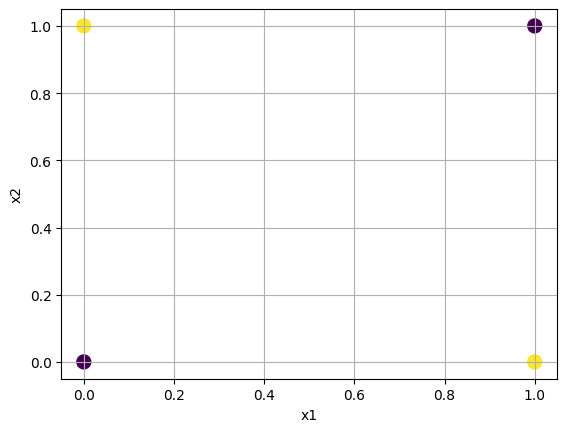

In [115]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
labels = [0, 1, 1, 0]

plt.scatter(x1, x2, c=labels, s=100)
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

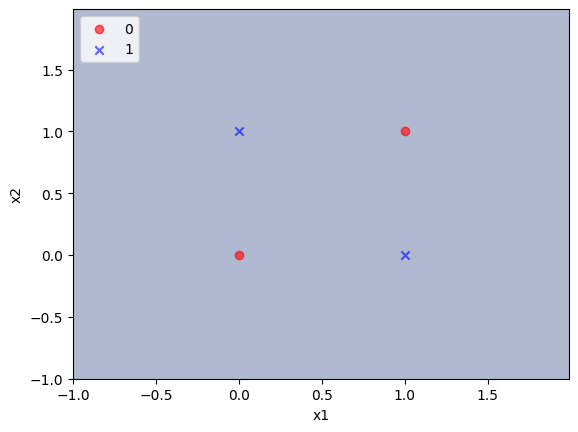

In [116]:
data = data = [(a, b, int(c)) for a, b, c in np.array([x1, x2, labels]).T]
tree = decision_tree_func(data)
plot_decision_boundary(tree, data)

As we can see, the decision tree algorithm did not many any initial split and predicts the whole domain as the 1 class

# Question 2.3

In [117]:
with open("Druns.txt", "r") as f:
    lines = f.readlines()
data = [tuple(map(float, line.strip().split())) for line in lines]

initial_entropy = entropy(data)

results = []

# For each candidate split on each feature calculate information gain ratio
for feature in range(2):
    for value in set(row[feature] for row in data):
        left = [row for row in data if row[feature] >= value]
        right = [row for row in data if row[feature] < value]

        left_entropy = entropy(left)
        right_entropy = entropy(right)

        split_entropy = (len(left) / len(data)) * left_entropy + (len(right) / len(data)) * right_entropy
        gain = initial_entropy - split_entropy

        # Handling the cases where left or right could be empty
        left_ratio = len(left) / len(data)
        right_ratio = len(right) / len(data)

        left_term = -left_ratio * math.log(left_ratio, 2) if left_ratio > 0 else 0
        right_term = -right_ratio * math.log(right_ratio, 2) if right_ratio > 0 else 0

        split_info = left_term + right_term
        metric_value = gain / split_info if split_info != 0 else 0  # information gain ratio
        metric_name = "Information Gain Ratio"

        results.append((f"x{feature+1} >= {value}", metric_name, metric_value))

# listing all possible cuts
for cut, metric_name, value in sorted(results, key=lambda x: x[2], reverse=True):
    print(f"{cut}: {metric_name} = {value:.4f}")


x2 >= 8.0: Information Gain Ratio = 0.4302
x2 >= 6.0: Information Gain Ratio = 0.2361
x2 >= 5.0: Information Gain Ratio = 0.1112
x1 >= 0.1: Information Gain Ratio = 0.1005
x2 >= -1.0: Information Gain Ratio = 0.1005
x2 >= 0.0: Information Gain Ratio = 0.0560
x2 >= 7.0: Information Gain Ratio = 0.0560
x2 >= 4.0: Information Gain Ratio = 0.0497
x2 >= 3.0: Information Gain Ratio = 0.0164
x2 >= 1.0: Information Gain Ratio = 0.0058
x2 >= 2.0: Information Gain Ratio = 0.0011
x1 >= 0.0: Information Gain Ratio = 0.0000
x2 >= -2.0: Information Gain Ratio = 0.0000


# Question 2.4

In [118]:
# going to make a different version of decision_tree() here because we need the tree structure and I don't want to go back and refactor the rest of the script c:
def decision_tree_struct(s):
    if len(s) == 0: return {"type": "leaf", "class": 1}
    gains = []
    for i in range(2):
        for x1, x2, y in s:
            threshold = x1 if i == 0 else x2
            g = calculate_split_gain_ratio(s, (lambda a, b: a if i == 0 else b), threshold)
            if g > 0: gains.append((g, i, threshold))
    if not gains:
        return {"type": "leaf", "class": 1 if sum(1 for _, _, y in s if y == 1) > len(s) / 2 else 0}
    _, i, threshold = max(gains)
    s1 = [(x1, x2, y) for x1, x2, y in s if (x1 if i == 0 else x2) >= threshold]
    s2 = [(x1, x2, y) for x1, x2, y in s if (x1 if i == 0 else x2) < threshold]
    return {
        "type": "node",
        "feature": i,
        "threshold": threshold,
        "left": decision_tree_struct(s1),
        "right": decision_tree_struct(s2)
    }


In [119]:
with open('D3leaves.txt') as f:
    data = [tuple(map(float, line.split())) for line in f]

def display_tree(node, depth=0):
    if node["type"] == "leaf":
        return "\t" * depth + f"Return {node['class']}\n"
    return "\t" * depth + f"If x{node['feature']+1} >= {node['threshold']}:\n" + display_tree(node["left"], depth+1) + "\t" * depth + f"Else:\n" + display_tree(node["right"], depth+1)

tree_struct = decision_tree_struct(data)
tree_repr = display_tree(tree_struct)
print(tree_repr)


If x2 >= 2.0:
	Return 1
Else:
	If x1 >= 10.0:
		Return 1
	Else:
		Return 0



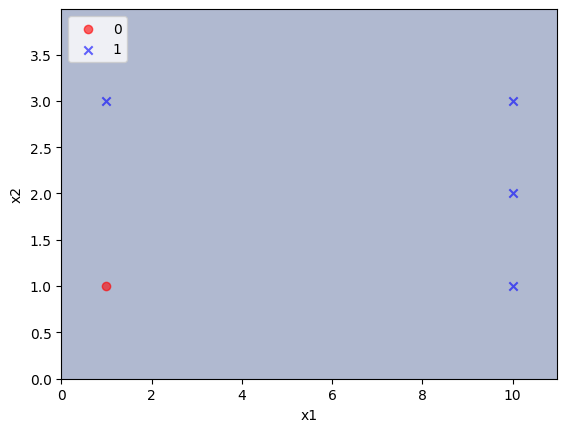

In [120]:
plot_decision_boundary(tree, data)

# Question 2.5

In [121]:
with open('D1.txt') as f:
    data = [tuple(map(float, line.split())) for line in f]

tree_struct = decision_tree_struct(data)
tree_repr = display_tree(tree_struct)
print(tree_repr)

If x2 >= 0.201829:
	Return 1
Else:
	Return 0



In [122]:
with open('D2.txt') as f:
    data = [tuple(map(float, line.split())) for line in f]

tree_struct = decision_tree_struct(data)
tree_repr = display_tree(tree_struct)
print(tree_repr)

If x1 >= 0.533076:
	If x2 >= 0.228007:
		If x2 >= 0.424906:
			Return 1
		Else:
			If x1 >= 0.708127:
				Return 1
			Else:
				If x2 >= 0.32625:
					If x1 >= 0.595471:
						If x1 >= 0.646007:
							Return 1
						Else:
							If x2 >= 0.403494:
								Return 1
							Else:
								Return 0
					Else:
						Return 0
				Else:
					Return 0
	Else:
		If x1 >= 0.887224:
			If x2 >= 0.037708:
				If x2 >= 0.082895:
					Return 1
				Else:
					If x1 >= 0.960783:
						Return 1
					Else:
						Return 0
			Else:
				Return 0
		Else:
			If x1 >= 0.850316:
				If x2 >= 0.169053:
					Return 1
				Else:
					Return 0
			Else:
				Return 0
Else:
	If x2 >= 0.88635:
		If x1 >= 0.041245:
			If x1 >= 0.104043:
				Return 1
			Else:
				If x2 >= 0.964767:
					Return 1
				Else:
					Return 0
		Else:
			Return 0
	Else:
		If x2 >= 0.691474:
			If x1 >= 0.254049:
				Return 1
			Else:
				If x1 >= 0.191915:
					If x2 >= 0.792752:
						Return 1
					Else:
						Return 0
				Else:
					If x2 >= 0.

# Question 2.6

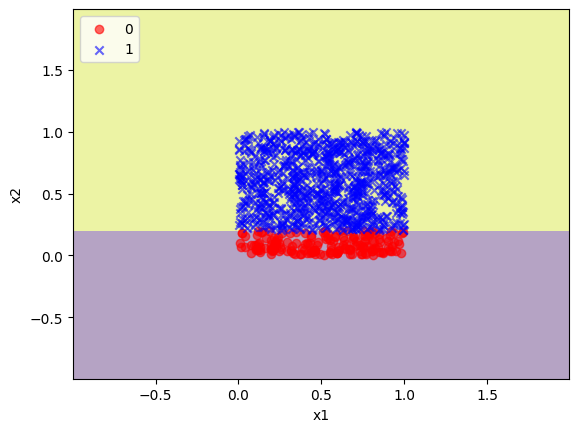

In [123]:

with open('D1.txt') as f:
    data = [tuple(map(float, line.split())) for line in f]

tree = decision_tree_func(data)
plot_decision_boundary(tree, data)

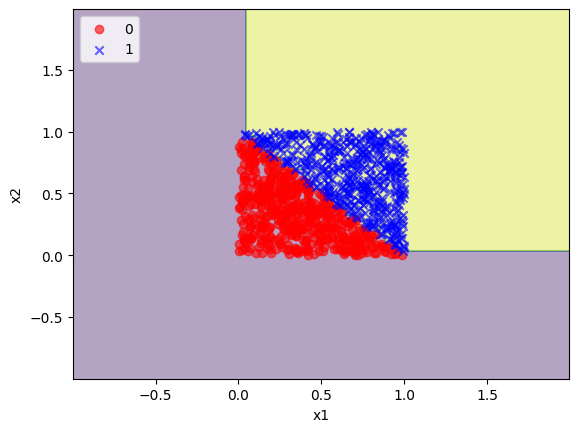

In [124]:

with open('D2.txt') as f:
    data = [tuple(map(float, line.split())) for line in f]

tree = decision_tree_func(data)
plot_decision_boundary(tree, data)

In [125]:
# Using the function
accuracy = compute_accuracy(tree, data)
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

Accuracy on the training set: 100.00%


# Question 2.7

In [126]:
import random

with open('Dbig.txt', 'r') as f:
    data = [tuple(map(float, line.split())) for line in f]

random.shuffle(data)

train_data = data[:8192]
test_data = data[8192:]

In [127]:
D_32 = train_data[:32]
D_128 = train_data[:128]
D_512 = train_data[:512]
D_2048 = train_data[:2048]
D_8192 = train_data

In [128]:
def count_nodes(tree):
    if tree["type"] == "leaf":
        return 1
    return 1 + count_nodes(tree["left"]) + count_nodes(tree["right"])

yo


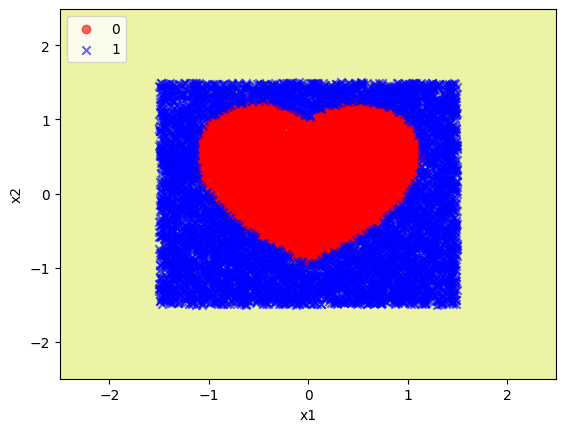

yo


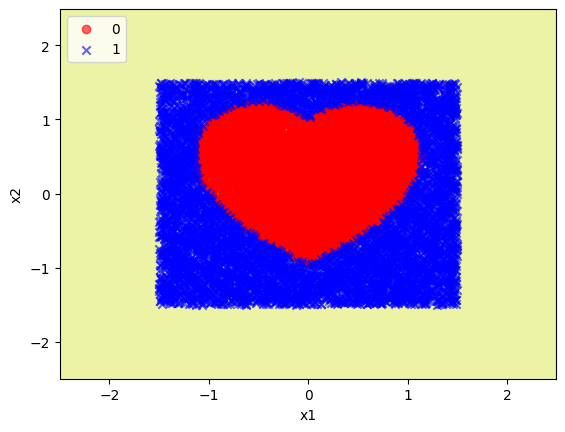

yo


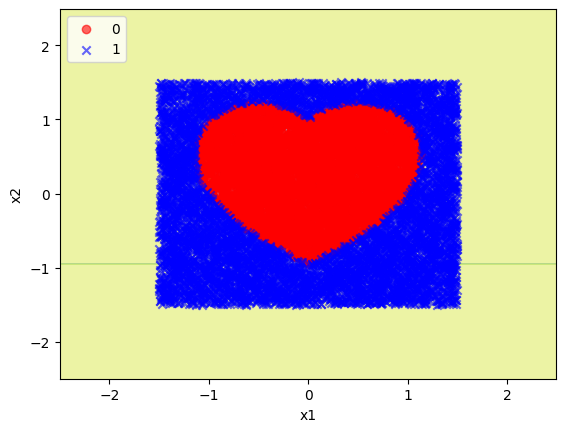

yo


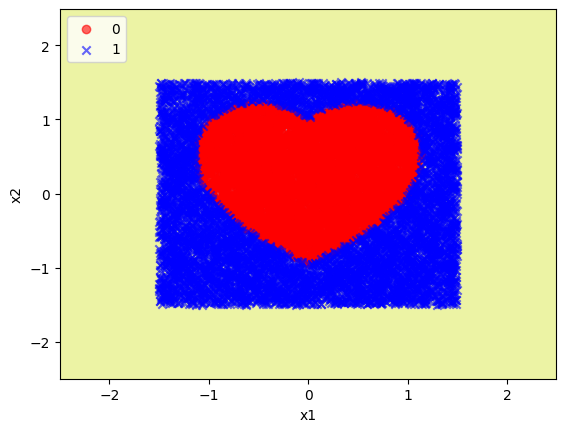

yo


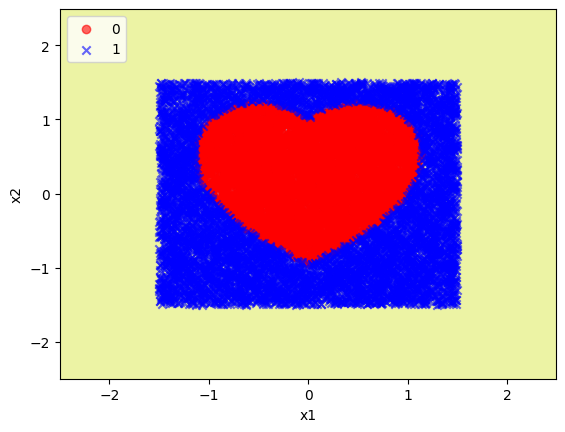

n = 32, number of nodes = 13, err_n = -88.4358
n = 128, number of nodes = 23, err_n = -91.0354
n = 512, number of nodes = 55, err_n = -93.7456
n = 2048, number of nodes = 133, err_n = -95.1283
n = 8192, number of nodes = 261, err_n = -97.3960


In [129]:
n_values = [32, 128, 512, 2048, 8192]
num_nodes_list = []
err_n_list = []
for D in [D_32, D_128, D_512, D_2048, D_8192]:
    print("yo")
    # Train a decision tree
    tree_func = decision_tree_func(D)
    tree_struct = decision_tree_struct(D)
    num_nodes = count_nodes(tree_struct)

    # Calculate error on test set
    predictions = [tree_func(x) for x in test_data]
    true_labels = [y for _, _, y in test_data]
    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct_predictions / len(predictions)
    error = 1 - accuracy
    # Append to lists
    num_nodes_list.append(num_nodes)
    err_n_list.append(error)

    plot_decision_boundary(tree_func, data)

# Print results
for n, nodes, err in zip(n_values, num_nodes_list, err_n_list):
    print(f"n = {n}, number of nodes = {nodes}, err_n = {err:.4f}")



In [130]:
correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
accuracy = 100 * correct_predictions / len(predictions)
print(accuracy)

98.39601769911505


[0.10564159 0.07964602 0.05254425 0.03871681 0.01603982]
[0.89435841 0.92035398 0.94745575 0.96128319 0.98396018]


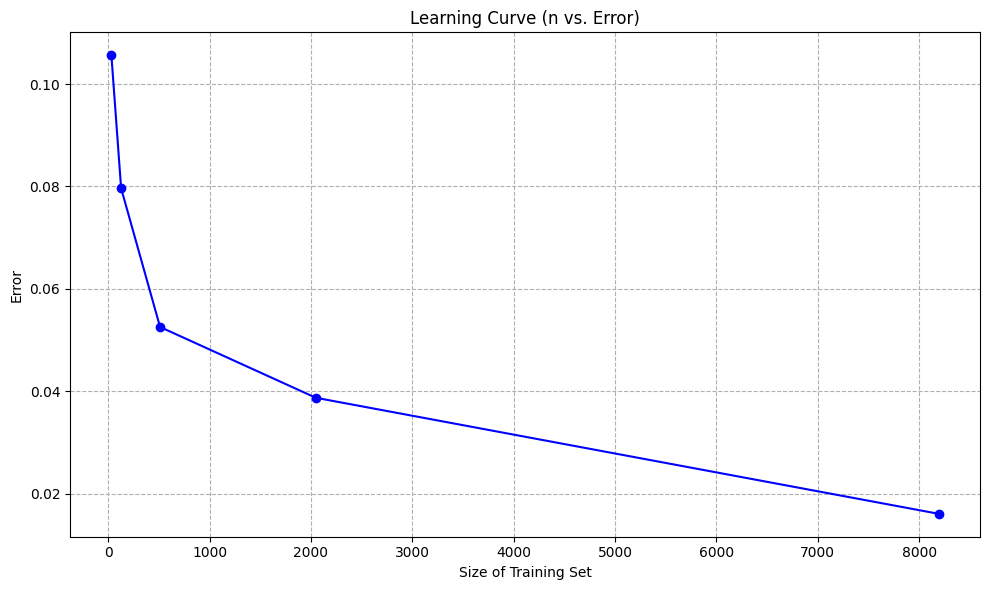

In [144]:
#error made in code and dont want to wait 25 mins for recompute
# n = 32, number of nodes = 13, err_n = 100-89.4358
# n = 128, number of nodes = 23, err_n = 100-92.0354
# n = 512, number of nodes = 55, err_n = 100-94.7456
# n = 2048, number of nodes = 133, err_n = 100-96.1283
# n = 8192, number of nodes = 261, err_n = 100-98.3960
fixed_accuracy = -(np.array(err_n_list) - 1)/100
fixed_error = 1-fixed_accuracy
print(fixed_error)
print(fixed_accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(n_values, fixed_error, marker='o', linestyle='-', color='b')
#plt.xscale('log')
plt.xlabel('Size of Training Set')
plt.ylabel('Error')
plt.title('Learning Curve (n vs. Error)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Question 3

In [155]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

results = []  # n, # nodes, err_n

datasets = [D_32, D_128, D_512, D_2048, D_8192]
for dataset in datasets:

    # Convert data to array format
    X = [(x1, x2) for x1, x2, _ in dataset]
    y = [label for _, _, label in dataset]

    # train/test/split
    X_train_big, X_test, y_train_big, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

    clf = DecisionTreeClassifier()
    clf.fit(X_train_big, y_train_big)
    predictions = clf.predict(X_test)
    err_n = 1 - accuracy_score(y_test, predictions)

    results.append((len(dataset), clf.tree_.node_count, err_n))

for n, nodes, err in results:
    print(f"Dataset size {n}:")
    print(f"Number of nodes: {nodes}")
    print(f"Testing set error (err_n): {err}\n")


Dataset size 32:
Number of nodes: 11
Testing set error (err_n): 0.4285714285714286

Dataset size 128:
Number of nodes: 25
Testing set error (err_n): 0.0

Dataset size 512:
Number of nodes: 53
Testing set error (err_n): 0.03883495145631066

Dataset size 2048:
Number of nodes: 99
Testing set error (err_n): 0.024390243902439046

Dataset size 8192:
Number of nodes: 233
Testing set error (err_n): 0.018303843807199516



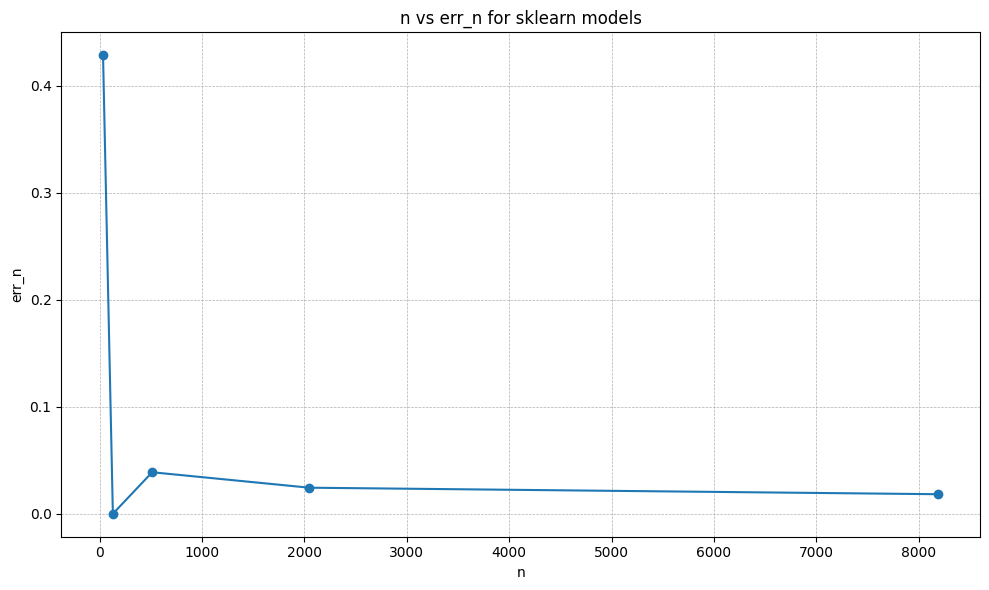

In [156]:
n_values = [result[0] for result in results]
err_n_values = [result[2] for result in results]

plt.figure(figsize=(10,6))
plt.plot(n_values, err_n_values, 'o-')

plt.xlabel('n')
plt.ylabel('err_n')
plt.title('n vs err_n for sklearn models')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()